In [1]:
import pandas as pd
import os
import numpy as np
import json

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
from sklearn import metrics
import sys
sys.path.insert(0, "/cellarold/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
from sklearn import linear_model
from regressors import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi
from scipy.stats import mannwhitneyu
from scipy import stats
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Lasso
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [4]:
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [6]:
from scipy.stats import mannwhitneyu
from scipy import stats
from sklearn import metrics

### Get UKBB risk variants

In [7]:
import json
with open('/cellar/users/mpagadal/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

In [7]:
def make_ukbb_prs(raw,sumstats,snps):
    
    print("{} PRS snps".format(len(snps)))
    
    #compile raw files
    compiled_raw=pd.read_csv(raw,delim_whitespace=True)
    
    #keep snps in list
    keep_snps=[]
    
    for x in snps:
        keep_snps.append([s for s in compiled_raw.columns if x in s][0])
        
    
    compiled_raw=compiled_raw[["IID"]+keep_snps]
#     print(compiled_raw)
    print("loading {} snps".format(len([x for x in compiled_raw.columns if "rs" in x])))
    print([x for x in compiled_raw.columns if "rs" in x])
#     return 0;
    #format raw files
    compiled_raw=compiled_raw.set_index("IID")
    compiled_raw=compiled_raw.T
    compiled_raw["min_allele"]=compiled_raw.index.str.split("_").str[-1]
    
    #remove duplicates
    compiled_raw["snp"]=compiled_raw.index.str.split("_").str[0]
    compiled_raw=compiled_raw[~compiled_raw["snp"].duplicated()]
    del compiled_raw["snp"]
    
    compiled_raw.index=compiled_raw.index.str.split("_").str[0]
#     print(compiled_raw)
    #reformat summary
    summary_merge=sumstats[["ID","A1","OR"]].copy()
    summary_merge=summary_merge.drop_duplicates(subset="ID",keep="first")
    summary_merge=summary_merge.set_index("ID")
#     summary_merge.index=summary_merge.index.str.rsplit(":",2).str[0]
#     print(summary_merge)
    #annotate the genotypes
    compiled_raw=pd.merge(compiled_raw,summary_merge, left_index=True,right_index=True,how="left")
    print("{} snps missing weight".format(len(compiled_raw[compiled_raw["OR"].isnull()])))
    
    compiled_raw["logOR"]=np.log2(compiled_raw["OR"])
    del compiled_raw["OR"]
    compiled_raw=compiled_raw[~compiled_raw["logOR"].isnull()] #remove null weights
    compiled_raw["logOR"]=np.where(compiled_raw["min_allele"]!=compiled_raw["A1"],compiled_raw["logOR"]*-1,compiled_raw["logOR"]) #orient the odds ratio
    print("switching {} genotypes".format(len(compiled_raw[compiled_raw["min_allele"]!=compiled_raw["A1"]]))) #number of mismatched genotypes

    del compiled_raw["min_allele"]
    del compiled_raw["A1"]

    #get beta values
    mp_beta=dict(zip(compiled_raw.index,compiled_raw["logOR"]))
    compiled_raw_switch=compiled_raw.iloc[:,:-1].T
    
    #align to all positive snps
    switch_snps=[k for k,v in mp_beta.items() if v < 0]
    
    compiled_raw_switch=compiled_raw_switch.fillna(0)
    
    for x in switch_snps:
        compiled_raw_switch[x]=2-compiled_raw_switch[x]
        
    compiled_raw_switch=compiled_raw_switch.T
    compiled_raw_switch["beta"]=compiled_raw_switch.index.map(mp_beta)
    compiled_raw_switch["beta"]=abs(compiled_raw_switch["beta"])
    compiled_raw_switch=compiled_raw_switch.astype(float)
    
    #compile weighted genotypes

    raw_prs=compiled_raw_switch.iloc[:,:-1].mul(compiled_raw_switch["beta"],axis=0).sum(axis=0).reset_index()
    raw_prs.columns=["IID","PRS"]
    
    return(raw_prs)

In [67]:
def quantile_plot(df,form,num,lin_log):
    '''
    df: dataframe with PRS and pheno/cov in form
    prs: prs column
    form: formula for analysis
    num: number of quantiles
    '''
    
    if lin_log == "logistic":
        
        quant=[]
        odds=[]
        se=[]

        for i in range(num):
            quant.append(str((100/num)*i))
    
            #make groupings for logistic regression
            
            cases=df[(df["PRS"]>df["PRS"].quantile((1/num)*i))&(df["PRS"]<df["PRS"].quantile((1/num)*(i+1)))]["FID"].tolist()
            controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(df["PRS"]<df["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
            
            
            df_filt=df[df["FID"].isin(cases+controls)]
            df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)
#             print(str((100/num)*i), "Percentile")
#             print(df_filt["group"].value_counts())
            
            if i != int(num/2):
                model=smf.logit(form,data=df_filt).fit()
                odds.append(np.exp(model.params.tolist()[1]))
                se.append(model.bse.tolist()[1])
            else:
                odds.append(1)
                se.append(0)
                
        df_odds=pd.DataFrame({"quant":quant,"odds":odds,"se":se})
        return(df_odds)

In [9]:
def fdr(df,P):
    probabilities = df[P].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)

In [10]:
cancer_meqtls = pd.read_csv("../new_cancer_meqtls_clumped.csv")
cancer_meqtls_short = cancer_meqtls[["SNP", "rsid", "TAD_TYPE_50kb"]]
cancer_meqtls_short = cancer_meqtls_short.rename(columns={"rsid":"Var1_ID"})
cancer_meqtls_short

,SNP,Var1_ID,TAD_TYPE_50kb
0,16:74700743:C:G,rs4887783,Boundary-Active
1,10:88486374:A:G,rs17335168,Active
2,19:45868478:A:T,rs238407,Inter-TAD
3,16:89828862:T:C,rs6500442,Active
4,16:74482455:G:A,rs1132843,Boundary-Active
...,...,...,...
151,13:95136055:G:T,rs9301962,Inter-TAD
152,7:5584599:G:A,rs1725213,Active
153,2:215840829:G:A,rs7594021,Inter-TAD
154,11:86261616:C:G,rs17149169,Inactive


In [11]:
ukbb = pd.read_csv("/cellar/users/sgoudarzi/risk_score/new_compiled_ukbb.tsv", delimiter="\t")
ukbb_sig = ukbb[ukbb["Var1_Pval"]<0.05]

In [45]:
ukbb["Outcome"].value_counts()

C51-C58    156
C69-C72    156
C64-C68    156
C76-C80    156
C00-C14    156
C73-C75    156
C43-C44    156
C81-C96    156
C60-C63    156
C45-C49    156
C40-C41    156
C50-C50    156
C97-C97    156
C30-C39    156
C15-C26    156
Name: Outcome, dtype: int64

In [12]:
ukbb = fdr(ukbb, "Var1_Pval")
ukbb_sig_fdr = ukbb[ukbb["fdr"]<0.05]
ukbb_sig_fdr = ukbb_sig_fdr.reset_index(drop=True)
ukbb_sig_fdr

,Outcome,Var1_ID,Var1_Pos,Var1_MAF,Num_NonMissing,Analysis_Type,Num_Cases,N_Iter,Converged,Raw_LRT_pval,Var1_Pval,Var1_OR,Var1_SE,Overall_Pval_(LRT),Overall_Pval_adj_Bonferroni,Overall_Pval_adj_FDR,fdr,-log10(fdr)
0,C43-C44,rs6500442,16:89828862,T:0.586226,382031,logistic,14527,8,1,1.336598e-07,1.284180e-07,0.937713,0.012178,1.336600e-07,5.346390e-06,5.346390e-06,7.512453e-05,4.124218
1,C43-C44,rs8047581,16:89884502,T:0.577376,377468,logistic,14350,8,1,9.422251e-13,1.073170e-12,1.092080,0.012370,9.422250e-13,3.768900e-11,3.768900e-11,2.511218e-09,8.600116
2,C81-C96,rs3935784,16:74604841,G:0.758227,382179,logistic,3902,9,1,1.127543e-04,9.937960e-05,0.903668,0.026025,1.127540e-04,4.510170e-03,4.510170e-03,4.650965e-02,1.332457
3,C43-C44,rs3743861,16:89818340,G:0.584587,382659,logistic,14555,8,1,9.965952e-11,9.305360e-11,0.924265,0.012158,9.965950e-11,3.986380e-09,3.986380e-09,7.258181e-08,7.139172
4,C43-C44,rs1006548,16:89844043,T:0.776296,381312,logistic,14508,8,1,1.550937e-11,2.276260e-11,1.107610,0.015284,1.550940e-11,6.203750e-10,6.203750e-10,2.663224e-08,7.574592


In [13]:
ukbb_annot = pd.merge(ukbb_sig, cancer_meqtls_short, on="Var1_ID")
ukbb_annot["ukbb_a1"]=ukbb_annot["Var1_MAF"].str.split(":").str[0]
ukbb_annot["logOR"]=np.log10(ukbb_annot["Var1_OR"])

In [40]:
ukbb_annot

,Outcome,Var1_ID,Var1_Pos,Var1_MAF,Num_NonMissing,Analysis_Type,Num_Cases,N_Iter,Converged,Raw_LRT_pval,Var1_Pval,Var1_OR,Var1_SE,Overall_Pval_(LRT),Overall_Pval_adj_Bonferroni,Overall_Pval_adj_FDR,SNP,TAD_TYPE_50kb,ukbb_a1,logOR
0,C64-C68,rs62051918,16:74613781,T:0.808744,381918,logistic,3471,9,1,0.025233,0.024264,0.934351,0.030140,0.025233,1.000000,0.987886,16:74613781:T:C,Active,T,-0.029490
1,C40-C41,rs4671408,2:61888702,C:0.52334,359853,logistic,140,12,1,0.026579,0.027580,1.306910,0.121490,0.026579,1.000000,0.618814,2:61888702:C:T,Inter-TAD,C,0.116246
2,C69-C72,rs12614048,2:209295636,C:0.629453,381757,logistic,781,10,1,0.019709,0.020476,1.131880,0.053454,0.019709,0.788354,0.597900,2:209295636:C:T,Inter-TAD,C,0.053800
3,C00-C14,rs12614048,2:209295636,C:0.629453,381757,logistic,974,10,1,0.030730,0.030116,0.904041,0.046519,0.030730,1.000000,0.597900,2:209295636:C:T,Inter-TAD,C,-0.043812
4,C15-C26,rs6915200,6:156669828,A:0.594481,382687,logistic,7514,8,1,0.006968,0.006903,0.955661,0.016788,0.006968,0.278712,0.139356,6:156669828:A:T,Inter-TAD,A,-0.019696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,C60-C63,rs6533181,4:106074826,G:0.631813,382839,logistic,7096,11,1,0.001038,0.001015,0.943269,0.017772,0.001038,0.041536,0.020768,4:106074826:G:T,Inter-TAD,G,-0.025364
123,C73-C75,rs6533181,4:106074826,G:0.631813,382839,logistic,501,10,1,0.009559,0.010251,1.188710,0.067337,0.009559,0.382350,0.096879,4:106074826:G:T,Inter-TAD,G,0.075076
124,C81-C96,rs6533181,4:106074826,G:0.631813,382839,logistic,3906,9,1,0.009688,0.009907,1.063280,0.023793,0.009688,0.387515,0.096879,4:106074826:G:T,Inter-TAD,G,0.026648
125,C81-C96,rs8061670,16:74690631,T:0.912462,381887,logistic,3899,9,1,0.015087,0.013885,0.908851,0.038848,0.015087,0.603490,0.603490,16:74690631:T:C,Boundary-Active,T,-0.041507


In [14]:
ukbb_sig["Outcome"].value_counts()

C51-C58    14
C60-C63    14
C15-C26    13
C64-C68    12
C40-C41    12
C81-C96    11
C76-C80     7
C43-C44     7
C69-C72     7
C50-C50     6
C45-C49     6
C00-C14     6
C30-C39     5
C73-C75     4
C97-C97     3
Name: Outcome, dtype: int64

#### Breast Cancer

In [36]:
#group1_sumstats=ukbb_annot[ukbb_annot["group"]=="group1"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
annot_short=ukbb_annot[["Var1_ID", "ukbb_a1","Var1_OR","Outcome"]]
annot_short_breast=annot_short[annot_short["Outcome"]=="C50-C50"]
annot_short_breast.columns=["ID","A1","OR","Outcome"]
#annot_short_melanoma["ID"] = annot_short_melanoma["ID"]+"_"+annot_short_melanoma["A1"]
annot_short_breast = annot_short_breast.reset_index(drop=True)

In [66]:
annot_short_breast

,ID,A1,OR,Outcome
0,rs1882448,C,1.063310,C50-C50
1,rs4424910,A,0.963493,C50-C50
2,rs2315511,G,1.042200,C50-C50
3,rs16944804,G,1.124820,C50-C50
4,rs6546575,G,0.969659,C50-C50
5,rs7551015,G,1.031620,C50-C50


In [37]:
breast_prs=make_ukbb_prs("/cellar/users/sgoudarzi/risk_score/new_ukbb_tad_meqtl.raw",annot_short_breast,annot_short_breast["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
controls = []
cases = []
for i, row in icd.iterrows():
    if row["C50-C50"] == 1:
        cases.append(row["FID"])
        continue
    temp = True
    for col in icd:
        if "-" in col and col != "C50-C50":
            if row[col] == 1:
                temp = False
                break
    if temp:
        controls.append(row["FID"])
all_cols = controls+cases
icd = icd[icd['FID'].isin(all_cols)]
icd = icd.reset_index(drop=True)
breast_prs=pd.merge(breast_prs,icd,on="IID",how="left")

6 PRS snps
loading 6 snps
['rs1882448_T', 'rs4424910_C', 'rs2315511_A', 'rs16944804_C', 'rs6546575_C', 'rs7551015_T']
0 snps missing weight
switching 6 genotypes


Text(0.5, 0, 'PRS')

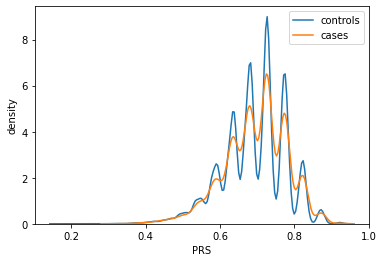

In [44]:
sns.kdeplot(breast_prs[breast_prs["C50-C50"]==0]["PRS"],label="controls")
sns.kdeplot(breast_prs[breast_prs["C50-C50"]==1]["PRS"],label="cases")
plt.ylabel("density")
plt.legend()
plt.xlabel("PRS")

In [38]:
cat1 = breast_prs[breast_prs["C50-C50"]==0]
cat2 = breast_prs[breast_prs["C50-C50"]==1]
mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]

3.452221881218037e-08

In [89]:
breast_prs["C50-C50"].value_counts()

0.0    177834
1.0     11188
Name: C50-C50, dtype: int64

In [68]:
breast_prs["breast"]=breast_prs["C50-C50"]
breast_odds=quantile_plot(breast_prs,"breast ~ group + AGE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

<ipython-input-67-ced5c5d3e845>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.186278
         Iterations 9


<ipython-input-67-ced5c5d3e845>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.185932
         Iterations 9


<ipython-input-67-ced5c5d3e845>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.190925
         Iterations 9


<ipython-input-67-ced5c5d3e845>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.191539
         Iterations 9


<ipython-input-67-ced5c5d3e845>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.188352
         Iterations 9


<ipython-input-67-ced5c5d3e845>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)
<ipython-input-67-ced5c5d3e845>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.194488
         Iterations 10


<ipython-input-67-ced5c5d3e845>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.196322
         Iterations 9


<ipython-input-67-ced5c5d3e845>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.195926
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.201232
         Iterations 9


<ipython-input-67-ced5c5d3e845>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


In [71]:
breast_prs["breast"].value_counts()

0.0    177834
1.0     11188
Name: breast, dtype: int64

#### Compare the Bottom 20% Quantile PRS with the Top 20% Quantile Using Fisher's Exact

In [70]:
bottom_20_prs = breast_prs[(breast_prs["PRS"]<breast_prs["PRS"].quantile(0.2))]
top_20_prs = breast_prs[(breast_prs["PRS"]>breast_prs["PRS"].quantile(0.8))]
bottom_20_prs

,IID,PRS,FID,D55-D59,D80-D89,E70-E90,I70-I79,K20-K31,K50-K52,K70-K77,...,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,breast
1,5607583,0.592127,5607583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.016920,0.001305,0.004770,-0.006398,-0.002327,-0.004221,-0.015524,-0.005614,-0.001290,0.0
3,5138852,0.592127,5138852.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.003246,-0.000597,0.012908,0.004790,-0.008045,-0.000175,0.002480,-0.006394,0.008965,0.0
17,4484106,0.577406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,3472607,0.609560,3472607.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004100,-0.001562,0.014730,0.008077,0.006730,0.002909,-0.001192,-0.010980,0.000714,0.0
23,3506007,0.621057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495443,2327744,0.532494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
495450,1134445,0.532494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
495451,4642696,0.577406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
495459,3387495,0.503564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
table_2d = [[len(bottom_20_prs[bottom_20_prs["breast"]==0]), len(top_20_prs[top_20_prs["breast"]==0])], [len(bottom_20_prs[bottom_20_prs["breast"]==1]), len(top_20_prs[top_20_prs["breast"]==1])]]
odd_ratio, p_value = stats.fisher_exact(table_2d)
print(p_value)

4.2510015024003916e-07


### Draw UKBB PRS Quantile Plot 

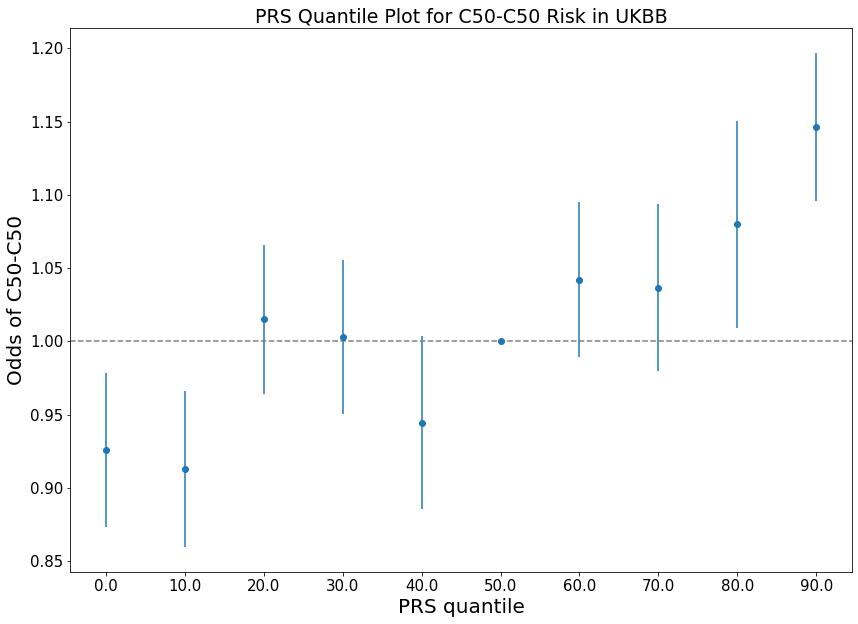

In [50]:
fig2 = plt.figure(figsize=(14,10))
plt.errorbar(x=breast_odds["quant"].tolist(),y=breast_odds["odds"].tolist(),yerr=breast_odds["se"].tolist(),fmt="o")
plt.xlabel("PRS quantile", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Odds of C50-C50", fontsize=20)
plt.axhline(1,linestyle="--",color="gray")
plt.title("PRS Quantile Plot for C50-C50 Risk in UKBB" ,fontsize=19)
plt.savefig("/cellar/users/sgoudarzi/plots/lasso_xgboost/breast_validation/quantile_breast_ukbb.png")
plt.savefig("/cellar/users/sgoudarzi/plots/lasso_xgboost/breast_validation/quantile_breast_ukbb.pdf")

### UKBB Train XGBoost

In [14]:
pheno=pd.read_csv("/cellar/users/sgoudarzi/modeling_risk/lasso_xgboost/ukbb_pheno.txt",delim_whitespace=True)
controls = []
cases = []
for i, row in pheno.iterrows():
    if row["C50-C50"] == 1:
        cases.append(row["FID"])
        continue
    temp = True
    for col in pheno:
        if "-" in col and col != "C50-C50":
            if row[col] == 1:
                temp = False
                break
    if temp:
        controls.append(row["FID"])
all_cols = controls+cases
pheno = pheno[pheno['FID'].isin(all_cols)]
pheno = pheno.reset_index(drop=True)
breast_pheno = dict(zip(pheno["FID"],pheno["C50-C50"]))

In [15]:
orig=pd.read_csv("/cellar/users/sgoudarzi/modeling_risk/lasso_xgboost/ukbb_pheno.txt",delim_whitespace=True)
len(orig)

394034

In [21]:
pheno["C50-C50"].value_counts()

0    177834
1     11188
Name: C50-C50, dtype: int64

In [16]:
all_phenos = ["breast_pheno"]

In [16]:
cols = pheno.columns
cancer_phenos = []
for p in cols:
    if "-" in p and "C" in p:
        cancer_phenos.append(p)
cancer_phenos = pd.unique(cancer_phenos)
cancer_phenos

array(['C73-C75', 'C81-C96', 'C40-C41', 'C50-C50', 'C00-C14', 'C45-C49',
       'C30-C39', 'C97-C97', 'C76-C80', 'C60-C63', 'C15-C26', 'C51-C58',
       'C43-C44', 'C69-C72', 'C64-C68'], dtype=object)

In [17]:
covariates = pd.DataFrame()
for col in pheno:
    if col == "FID":
        covariates[col] = pheno[col]
    else:
        if "PC" in col or "AGE" in col or "SEX" in col:
            covariates[col] = pheno[col]
covariates

,FID,AGE,SEX,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1435562,42,1,-0.004528,-0.000386,-0.001024,-0.005982,0.001045,-0.009649,-0.015201,-0.024479,-0.009430,0.007605
1,2559782,58,1,0.003701,-0.013474,0.003878,-0.002364,-0.000349,-0.005647,0.004750,0.006802,0.003787,0.002984
2,2666253,55,0,-0.026115,0.025796,-0.001125,-0.003029,0.001340,-0.001907,0.005306,0.001638,-0.001459,-0.000843
3,2666253,55,0,-0.026115,0.025796,-0.001125,-0.003029,0.001340,-0.001907,0.005306,0.001638,-0.001459,-0.000843
4,1643600,53,1,-0.001952,0.000049,0.000247,0.006593,-0.000460,-0.000952,-0.004902,0.007431,0.003226,0.001012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189017,1298419,61,0,-0.006047,0.009450,0.009765,-0.008275,-0.001272,0.007527,-0.000633,0.003105,-0.007179,-0.003348
189018,4581799,61,0,0.000941,-0.018452,0.006200,-0.012634,-0.012467,0.009314,-0.003472,0.003992,-0.016187,-0.000234
189019,3658014,49,0,0.004667,-0.006462,0.005520,0.011345,0.009976,0.002600,0.007303,0.001734,-0.002715,-0.004062
189020,4838981,50,0,-0.012646,0.011061,0.008479,0.015328,-0.007159,0.012189,-0.010695,-0.006369,0.009511,0.009587


In [73]:
covariates["SEX"].value_counts()

1    105711
0     83311
Name: SEX, dtype: int64

In [18]:
geno = pd.read_csv("/cellar/users/sgoudarzi/ukbb/ukbb_genotype_aligned.csv", sep="\t")
geno

,FID,IID,PAT,MAT,SEX,PHENOTYPE,19:30286245:A:G_A,19:30322427:A:G_A,19:30602910:T:C_T,19:34095917:G:A_G,...,10:105055912:A:G_A,10:105169859:G:A_G,17:73794047:T:G_T,11:23034213:T:C_T,11:23220093:T:G_T,11:86261616:C:G_C,11:128115740:T:C_T,22:24146560:C:T_C,22:30509399:T:C_T,5:66864266:G:A_G
0,5309711,5309711,0,0,1,-9,2.0,1.0,1,2.0,...,1.0,2.00000,2,1.00000,2.0,1.00390,2.0,0.0,2.0,1.0
1,5607583,5607583,0,0,2,-9,1.0,0.0,1,1.0,...,2.0,1.00000,2,0.99610,1.0,1.00000,2.0,0.0,2.0,1.0
2,3534526,3534526,0,0,2,-9,2.0,1.0,2,2.0,...,1.0,2.00000,2,1.00000,2.0,2.00000,1.0,1.0,2.0,2.0
3,5138852,5138852,0,0,2,-9,2.0,1.0,2,2.0,...,1.0,1.00000,2,1.00000,2.0,2.00000,2.0,0.0,2.0,2.0
4,2187179,2187179,0,0,2,-9,2.0,2.0,2,2.0,...,2.0,1.00000,2,1.00000,2.0,1.16077,2.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487404,3387495,3387495,0,0,2,-9,1.0,1.0,1,2.0,...,0.0,2.00000,2,1.00000,2.0,2.00000,2.0,0.0,2.0,2.0
487405,1801702,1801702,0,0,2,-9,1.0,1.0,2,1.0,...,2.0,2.00000,2,1.29803,2.0,2.00000,2.0,1.0,2.0,2.0
487406,4639336,4639336,0,0,1,-9,2.0,1.0,2,2.0,...,1.0,1.95685,1,0.00000,1.0,2.00000,2.0,0.0,2.0,1.0
487407,2621795,2621795,0,0,2,-9,2.0,0.0,1,2.0,...,0.0,2.00000,2,1.00000,2.0,2.00000,2.0,0.0,2.0,2.0


In [19]:
all_meqtls = pd.read_csv("../new_cancer_meqtls_clumped.csv")
meqtls_risk = pd.read_csv("../risk_score/new_compiled_ukbb.tsv", delimiter="\t")
meqtls_risk

,Outcome,Var1_ID,Var1_Pos,Var1_MAF,Num_NonMissing,Analysis_Type,Num_Cases,N_Iter,Converged,Raw_LRT_pval,Var1_Pval,Var1_OR,Var1_SE,Overall_Pval_(LRT),Overall_Pval_adj_Bonferroni,Overall_Pval_adj_FDR
0,C64-C68,rs62051918,16:74613781,T:0.808744,381918,logistic,3471,9,1,0.025233,0.024264,0.934351,0.030140,0.025233,1.0,0.987886
1,C73-C75,rs62051918,16:74613781,T:0.808744,381918,logistic,498,10,1,0.279618,0.284178,1.092890,0.082937,0.279618,1.0,0.987886
2,C00-C14,rs62051918,16:74613781,T:0.808744,381918,logistic,976,10,1,0.328183,0.331061,1.058740,0.058727,0.328183,1.0,0.987886
3,C45-C49,rs62051918,16:74613781,T:0.808744,381918,logistic,811,10,1,0.334184,0.331269,0.941449,0.062101,0.334184,1.0,0.987886
4,C40-C41,rs62051918,16:74613781,T:0.808744,381918,logistic,149,12,1,0.352346,0.359727,1.151260,0.153797,0.352346,1.0,0.987886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,C30-C39,rs8061670,16:74690631,T:0.912462,381887,logistic,2930,9,1,0.551034,0.553418,1.028290,0.047067,0.551034,1.0,0.973539
2336,C76-C80,rs8061670,16:74690631,T:0.912462,381887,logistic,11524,8,1,0.601035,0.601403,0.987731,0.023632,0.601035,1.0,0.973539
2337,C50-C50,rs8061670,16:74690631,T:0.912462,381887,logistic,10844,10,1,0.790882,0.797976,0.993727,0.024585,0.790882,1.0,0.973539
2338,C64-C68,rs8061670,16:74690631,T:0.912462,381887,logistic,3475,9,1,0.900524,0.896960,0.994479,0.042749,0.900524,1.0,0.973539


In [20]:
meqtls_risk_sig = meqtls_risk[meqtls_risk["Var1_Pval"]<0.05]
meqtls_risk_sig = meqtls_risk_sig.reset_index(drop=True)
meqtls_risk_sig

,Outcome,Var1_ID,Var1_Pos,Var1_MAF,Num_NonMissing,Analysis_Type,Num_Cases,N_Iter,Converged,Raw_LRT_pval,Var1_Pval,Var1_OR,Var1_SE,Overall_Pval_(LRT),Overall_Pval_adj_Bonferroni,Overall_Pval_adj_FDR
0,C64-C68,rs62051918,16:74613781,T:0.808744,381918,logistic,3471,9,1,0.025233,0.024264,0.934351,0.030140,0.025233,1.000000,0.987886
1,C40-C41,rs4671408,2:61888702,C:0.52334,359853,logistic,140,12,1,0.026579,0.027580,1.306910,0.121490,0.026579,1.000000,0.618814
2,C69-C72,rs12614048,2:209295636,C:0.629453,381757,logistic,781,10,1,0.019709,0.020476,1.131880,0.053454,0.019709,0.788354,0.597900
3,C00-C14,rs12614048,2:209295636,C:0.629453,381757,logistic,974,10,1,0.030730,0.030116,0.904041,0.046519,0.030730,1.000000,0.597900
4,C15-C26,rs6915200,6:156669828,A:0.594481,382687,logistic,7514,8,1,0.006968,0.006903,0.955661,0.016788,0.006968,0.278712,0.139356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,C60-C63,rs6533181,4:106074826,G:0.631813,382839,logistic,7096,11,1,0.001038,0.001015,0.943269,0.017772,0.001038,0.041536,0.020768
123,C73-C75,rs6533181,4:106074826,G:0.631813,382839,logistic,501,10,1,0.009559,0.010251,1.188710,0.067337,0.009559,0.382350,0.096879
124,C81-C96,rs6533181,4:106074826,G:0.631813,382839,logistic,3906,9,1,0.009688,0.009907,1.063280,0.023793,0.009688,0.387515,0.096879
125,C81-C96,rs8061670,16:74690631,T:0.912462,381887,logistic,3899,9,1,0.015087,0.013885,0.908851,0.038848,0.015087,0.603490,0.603490


In [21]:
meqtls_risk_sig_lst = pd.unique(list(meqtls_risk_sig["Var1_Pos"]))
meqtls_risk_sig_lst

array(['16:74613781', '2:61888702', '2:209295636', '6:156669828',
       '2:47785260', '20:57375308', '1:18774941', '10:88641501',
       '16:68814826', '3:70069621', '11:23220093', '16:74526649',
       '16:89828862', '12:57298771', '2:177941071', '2:61623476',
       '10:104963051', '22:24146560', '2:61836773', '16:74636961',
       '10:104780564', '2:214056540', '16:74482455', '10:104670832',
       '13:103554171', '10:104711940', '2:44246726', '5:66864266',
       '16:89884502', '19:30286245', '7:148698909', '8:90126767',
       '3:185903412', '19:30322427', '16:90038786', '16:74679883',
       '2:209239899', '2:60889037', '16:74552127', '16:74371543',
       '16:74714604', '16:74596183', '12:22992541', '2:61338832',
       '2:201216280', '16:74384296', '16:74604841', '15:40453075',
       '16:74698252', '16:89818340', '2:215840829', '16:10054912',
       '16:74478746', '2:61437487', '16:74592483', '13:91463947',
       '16:74556058', '16:74222799', '19:30602910', '2:26105585',
   

In [22]:
#filter the genotype file to significant meQTLs affecting cancer risk
sig_ukbb_geno = pd.DataFrame()
for col in geno:
    if col == "FID":
        sig_ukbb_geno["FID"] = geno[col]
        continue
    if "_" in col:
        tmp = col.split("_")[0].split(":")
        snp = tmp[0]+":"+tmp[1]
        if snp in meqtls_risk_sig_lst:
            sig_ukbb_geno[col] =  geno[col]
sig_ukbb_geno = pd.merge(sig_ukbb_geno, covariates, on="FID")
sig_ukbb_geno = sig_ukbb_geno.set_index("FID")
sig_ukbb_geno["breast_pheno"]=sig_ukbb_geno.index.map(breast_pheno)
sig_ukbb_geno = sig_ukbb_geno[sig_ukbb_geno["SEX"]==1]
del sig_ukbb_geno["SEX"] 
sig_ukbb_geno = sig_ukbb_geno.dropna()
sig_ukbb_geno

,19:30286245:A:G_A,19:30322427:A:G_A,19:30602910:T:C_T,20:56648906:G:A_G,20:57375308:T:C_T,8:90126767:C:G_C,8:115254906:C:T_C,15:40453075:G:A_G,16:10054912:A:G_A,16:11016508:G:A_G,...,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,breast_pheno
FID,,,,,,,,,,,,,,,,,,,,,
5607583,1.0,0.0000,1,2,1.0,2.0,2.0,2.0,0.0,2.0,...,-0.016920,0.001305,0.004770,-0.006398,-0.002327,-0.004221,-0.015524,-0.005614,-0.001290,0
3534526,2.0,1.0000,2,2,0.0,2.0,0.0,2.0,0.0,1.0,...,0.012710,-0.003276,0.006141,0.001139,0.003370,-0.008427,-0.001921,0.009822,-0.006333,0
5138852,2.0,1.0000,2,2,0.0,2.0,2.0,1.0,0.0,2.0,...,-0.003246,-0.000597,0.012908,0.004790,-0.008045,-0.000175,0.002480,-0.006394,0.008965,0
2187179,2.0,2.0000,2,2,0.0,1.0,1.0,1.0,0.0,2.0,...,-0.008452,-0.000948,-0.001641,0.004532,0.003766,0.007023,-0.010404,0.001035,0.003554,0
5796294,2.0,2.0000,1,2,1.0,2.0,1.0,2.0,1.0,2.0,...,0.004873,0.001836,0.029610,-0.000938,-0.006588,0.000817,-0.014341,-0.019459,-0.002546,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805078,2.0,2.0000,2,2,0.0,2.0,1.0,1.0,0.0,2.0,...,0.003554,-0.001167,-0.004453,0.010930,-0.006123,-0.011745,-0.004915,0.008156,0.004193,1
5419556,1.0,1.0039,1,2,1.0,2.0,2.0,1.0,1.0,2.0,...,-0.014346,0.003287,-0.002165,0.005481,-0.004609,0.011968,0.001146,-0.004162,-0.007909,0
5054617,2.0,0.9882,2,2,1.0,2.0,1.0,2.0,0.0,2.0,...,-0.009808,0.003241,-0.003035,-0.005086,-0.005217,0.003796,0.000020,0.000822,0.002577,0


In [22]:
sig_ukbb_geno["breast_pheno"].value_counts()

0    94871
1    10840
Name: breast_pheno, dtype: int64

#### Oversample Training to Balance Unbalanced Labels

In [23]:
def oversample_training(pheno, ukbb):
    ukbb_temp = pd.DataFrame()
    ukbb_temp = ukbb.copy()
    LASSO_x = ukbb_temp.drop([pheno], axis=1)
    LASSO_y = ukbb_temp[pheno]
    os = SMOTE(random_state=0)
    columns = LASSO_x.columns
    LASSO_x,LASSO_y=os.fit_resample(LASSO_x, LASSO_y)
    LASSO_x = pd.DataFrame(data=LASSO_x,columns=columns)
    LASSO_y= pd.DataFrame(data=LASSO_y,columns=[pheno])
    LASSO_y = LASSO_y[pheno]
    return LASSO_x, LASSO_y, ukbb_temp

#### Remove Outlier SNPs with Low MAFs Compared to Drive

In [24]:
remove_snps_validation = ['19:45825626:A:T', '19:45825626:T:A', '1:15914135:A:G', '1:15914135:G:A', '6:156669828:A:T', '6:156669828:T:A', '16:74592483:T:C', '16:74592483:C:T', '16:74596183:T:A', '16:74596183:A:T', '16:74698252:A:T', '16:74698252:T:A', '16:74700743:G:C', '16:74700743:C:G', '16:74711629:T:A', '16:74711629:A:T', '16:74711964:T:C', '16:74711964:C:T', '10:104780564:T:C', '10:104780564:C:T', '10:104928770:T:A', '10:104928770:A:T']
choose_cols = []
for cols in sig_ukbb_geno:
    snp = cols.split("_")[0]
    if snp not in remove_snps_validation:
        choose_cols.append(cols)
sig_ukbb_geno = sig_ukbb_geno[choose_cols]
sig_ukbb_geno

,19:30286245:A:G_A,19:30322427:A:G_A,19:30602910:T:C_T,20:56648906:G:A_G,20:57375308:T:C_T,8:90126767:C:G_C,8:115254906:C:T_C,15:40453075:G:A_G,16:10054912:A:G_A,16:11016508:G:A_G,...,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,breast_pheno
FID,,,,,,,,,,,,,,,,,,,,,
5607583,1.0,0.0000,1,2,1.0,2.0,2.0,2.0,0.0,2.0,...,-0.016920,0.001305,0.004770,-0.006398,-0.002327,-0.004221,-0.015524,-0.005614,-0.001290,0
3534526,2.0,1.0000,2,2,0.0,2.0,0.0,2.0,0.0,1.0,...,0.012710,-0.003276,0.006141,0.001139,0.003370,-0.008427,-0.001921,0.009822,-0.006333,0
5138852,2.0,1.0000,2,2,0.0,2.0,2.0,1.0,0.0,2.0,...,-0.003246,-0.000597,0.012908,0.004790,-0.008045,-0.000175,0.002480,-0.006394,0.008965,0
2187179,2.0,2.0000,2,2,0.0,1.0,1.0,1.0,0.0,2.0,...,-0.008452,-0.000948,-0.001641,0.004532,0.003766,0.007023,-0.010404,0.001035,0.003554,0
5796294,2.0,2.0000,1,2,1.0,2.0,1.0,2.0,1.0,2.0,...,0.004873,0.001836,0.029610,-0.000938,-0.006588,0.000817,-0.014341,-0.019459,-0.002546,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805078,2.0,2.0000,2,2,0.0,2.0,1.0,1.0,0.0,2.0,...,0.003554,-0.001167,-0.004453,0.010930,-0.006123,-0.011745,-0.004915,0.008156,0.004193,1
5419556,1.0,1.0039,1,2,1.0,2.0,2.0,1.0,1.0,2.0,...,-0.014346,0.003287,-0.002165,0.005481,-0.004609,0.011968,0.001146,-0.004162,-0.007909,0
5054617,2.0,0.9882,2,2,1.0,2.0,1.0,2.0,0.0,2.0,...,-0.009808,0.003241,-0.003035,-0.005086,-0.005217,0.003796,0.000020,0.000822,0.002577,0


In [25]:
sig_ukbb_geno = sig_ukbb_geno.rename(columns={"PHENOTYPE":"breast_pheno"})
sig_ukbb_geno

,19:30286245:A:G_A,19:30322427:A:G_A,19:30602910:T:C_T,20:56648906:G:A_G,20:57375308:T:C_T,8:90126767:C:G_C,8:115254906:C:T_C,15:40453075:G:A_G,16:10054912:A:G_A,16:11016508:G:A_G,...,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,breast_pheno
FID,,,,,,,,,,,,,,,,,,,,,
5607583,1.0,0.0000,1,2,1.0,2.0,2.0,2.0,0.0,2.0,...,-0.016920,0.001305,0.004770,-0.006398,-0.002327,-0.004221,-0.015524,-0.005614,-0.001290,0
3534526,2.0,1.0000,2,2,0.0,2.0,0.0,2.0,0.0,1.0,...,0.012710,-0.003276,0.006141,0.001139,0.003370,-0.008427,-0.001921,0.009822,-0.006333,0
5138852,2.0,1.0000,2,2,0.0,2.0,2.0,1.0,0.0,2.0,...,-0.003246,-0.000597,0.012908,0.004790,-0.008045,-0.000175,0.002480,-0.006394,0.008965,0
2187179,2.0,2.0000,2,2,0.0,1.0,1.0,1.0,0.0,2.0,...,-0.008452,-0.000948,-0.001641,0.004532,0.003766,0.007023,-0.010404,0.001035,0.003554,0
5796294,2.0,2.0000,1,2,1.0,2.0,1.0,2.0,1.0,2.0,...,0.004873,0.001836,0.029610,-0.000938,-0.006588,0.000817,-0.014341,-0.019459,-0.002546,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805078,2.0,2.0000,2,2,0.0,2.0,1.0,1.0,0.0,2.0,...,0.003554,-0.001167,-0.004453,0.010930,-0.006123,-0.011745,-0.004915,0.008156,0.004193,1
5419556,1.0,1.0039,1,2,1.0,2.0,2.0,1.0,1.0,2.0,...,-0.014346,0.003287,-0.002165,0.005481,-0.004609,0.011968,0.001146,-0.004162,-0.007909,0
5054617,2.0,0.9882,2,2,1.0,2.0,1.0,2.0,0.0,2.0,...,-0.009808,0.003241,-0.003035,-0.005086,-0.005217,0.003796,0.000020,0.000822,0.002577,0


In [26]:
LASSO_x_breast, LASSO_y_breast, ukbb_temp = oversample_training("breast_pheno", sig_ukbb_geno)

In [27]:
sig_ukbb_geno = sig_ukbb_geno.rename(columns={"breast_pheno":"PHENOTYPE"})
sig_ukbb_geno

,19:30286245:A:G_A,19:30322427:A:G_A,19:30602910:T:C_T,20:56648906:G:A_G,20:57375308:T:C_T,8:90126767:C:G_C,8:115254906:C:T_C,15:40453075:G:A_G,16:10054912:A:G_A,16:11016508:G:A_G,...,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PHENOTYPE
FID,,,,,,,,,,,,,,,,,,,,,
5607583,1.0,0.0000,1,2,1.0,2.0,2.0,2.0,0.0,2.0,...,-0.016920,0.001305,0.004770,-0.006398,-0.002327,-0.004221,-0.015524,-0.005614,-0.001290,0
3534526,2.0,1.0000,2,2,0.0,2.0,0.0,2.0,0.0,1.0,...,0.012710,-0.003276,0.006141,0.001139,0.003370,-0.008427,-0.001921,0.009822,-0.006333,0
5138852,2.0,1.0000,2,2,0.0,2.0,2.0,1.0,0.0,2.0,...,-0.003246,-0.000597,0.012908,0.004790,-0.008045,-0.000175,0.002480,-0.006394,0.008965,0
2187179,2.0,2.0000,2,2,0.0,1.0,1.0,1.0,0.0,2.0,...,-0.008452,-0.000948,-0.001641,0.004532,0.003766,0.007023,-0.010404,0.001035,0.003554,0
5796294,2.0,2.0000,1,2,1.0,2.0,1.0,2.0,1.0,2.0,...,0.004873,0.001836,0.029610,-0.000938,-0.006588,0.000817,-0.014341,-0.019459,-0.002546,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805078,2.0,2.0000,2,2,0.0,2.0,1.0,1.0,0.0,2.0,...,0.003554,-0.001167,-0.004453,0.010930,-0.006123,-0.011745,-0.004915,0.008156,0.004193,1
5419556,1.0,1.0039,1,2,1.0,2.0,2.0,1.0,1.0,2.0,...,-0.014346,0.003287,-0.002165,0.005481,-0.004609,0.011968,0.001146,-0.004162,-0.007909,0
5054617,2.0,0.9882,2,2,1.0,2.0,1.0,2.0,0.0,2.0,...,-0.009808,0.003241,-0.003035,-0.005086,-0.005217,0.003796,0.000020,0.000822,0.002577,0


### Generating and Preparing the Validation Datasets for DRIVE

In [28]:
drive_pheno=pd.read_csv("/cellar/shared/carterlab/projects/InSNPtion/data/drive/phenotypes/drive.pheno.tsv",delimiter="\t")
drive_pheno = drive_pheno.rename(columns={"#IID": "IID"})
drive_pheno = drive_pheno[drive_pheno["SEX"]==2]
drive_pheno["PHENOTYPE"] = drive_pheno["PHENOTYPE"].replace([1, 2], [0, 1])
drive_pheno

,IID,AGE,SEX,PHENOTYPE,FAMILY_HISTORY,ANCESTRY,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PHENOTYPE_ER_STATUS
0,BCAC-54974792_282470,64.0,2,1,NaN,AFR,-0.545105,0.039960,-0.009619,-0.009526,0.035536,-0.006333,0.001665,0.010697,0.010290,-0.007152,NaN
1,BCAC-51014473_282566,45.0,2,1,NaN,AFR,-0.452949,0.047492,-0.025505,-0.013426,0.038814,-0.015971,-0.014549,0.036292,0.003775,-0.007904,0.0
2,BCAC-12089156_282662,49.0,2,1,NaN,AFR,-0.610263,0.038117,-0.013794,0.008197,0.047425,-0.024568,-0.006606,0.021374,0.022090,0.002964,0.0
3,BCAC-95658930_282758,42.0,2,1,NaN,AFR,-0.609960,0.048670,-0.021063,0.007725,0.051808,-0.015644,-0.008186,0.019279,0.002408,0.000188,0.0
4,BCAC-51443138_282854,35.0,2,1,NaN,AFR,-0.607808,0.057020,-0.010712,0.000268,0.052750,-0.017442,-0.010570,0.006290,0.009872,-0.000181,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60010,BCAC-84531373_101279,59.0,2,0,NaN,EUR,0.027011,0.008320,-0.027688,-0.006850,-0.003140,-0.002906,-0.004004,-0.011498,0.001894,0.003146,NaN
60011,BCAC-19508141_102762,64.0,2,1,NaN,EUR,0.030753,0.009791,-0.013142,-0.009328,0.009964,-0.012945,-0.008844,-0.011362,0.001031,-0.003909,1.0
60012,BCAC-71331053_105134,71.0,2,1,NaN,EUR,0.026127,0.004366,-0.009765,0.015097,0.004133,0.001472,-0.005903,-0.003007,0.001814,0.003507,0.0
60013,BCAC-13068608_106595,66.0,2,0,NaN,EUR,0.030592,0.010267,-0.017148,-0.019092,0.000116,-0.007339,0.006462,0.001649,-0.003933,-0.010574,NaN


In [29]:
drive_pheno

,FID,IID,D55-D59,D80-D89,E70-E90,I70-I79,K20-K31,K50-K52,K70-K77,K80-K87,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10


In [29]:
genotype = pd.read_csv("../drive_breast/drive_breast_genotype_aligned.csv", delim_whitespace=True)
del genotype["PHENOTYPE"]
del genotype["FID"]
del genotype["PAT"]
del genotype["MAT"]
del genotype["SEX"]
genotype

,IID,15:40453075:G:A_G,15:67447895:A:G_A,15:91443059:T:C_T,2:25229434:T:A_T,2:26105585:G:C_G,2:44246726:C:G_C,2:47652455:C:T_C,2:47736061:C:G_C,2:47785260:T:C_T,...,17:73794047:T:G_T,1:15817090:C:T_C,1:15914135:A:G_A,1:18247811:G:T_G,1:18273842:T:G_T,1:18774941:T:A_T,1:52056757:A:T_A,1:163436669:G:T_G,1:201465839:T:C_T,1:241428657:G:A_G
0,BCAC-10002966_266541,2,2,1,2,2,0,2,2,0,...,0,2,2,1,0,2,2,1,0,2
1,BCAC-10004806_103990,1,1,1,2,1,2,2,2,0,...,2,2,2,2,0,2,2,2,2,1
2,BCAC-10006378_100061,2,1,1,2,1,0,2,2,0,...,1,2,2,2,0,2,2,2,0,2
3,BCAC-10013470_300068,1,2,1,1,2,0,2,2,0,...,2,2,2,2,1,1,2,2,0,2
4,BCAC-10014103_277737,2,2,0,2,2,1,2,2,0,...,2,2,2,1,1,2,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60010,BCAC-99996920_267727,2,2,1,2,1,0,2,2,0,...,0,2,2,1,2,2,2,2,2,2
60011,BCAC-99997709_327042,2,1,2,2,2,2,2,2,0,...,1,2,2,2,0,2,2,2,0,2
60012,BCAC-99998412_285498,2,1,2,2,0,1,1,1,1,...,2,2,2,2,1,2,2,2,1,1
60013,BCAC-99998841_326518,1,2,1,2,1,1,2,2,0,...,2,1,1,1,1,1,2,2,0,2


In [30]:
validation_breast_data = pd.merge(drive_pheno, genotype, on="IID")
validation_breast_data = validation_breast_data.reset_index(drop=True)
cols = []
for col in validation_breast_data:
    if col == "IID" or col == "AGE" or "PC" in col or ":" in col or col == "PHENOTYPE":
        cols.append(col)
validation_breast_data = validation_breast_data[cols]
validation_breast_data = validation_breast_data.dropna()
validation_breast_data = validation_breast_data.set_index("IID")
validation_breast_data

,AGE,PHENOTYPE,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,17:73794047:T:G_T,1:15817090:C:T_C,1:15914135:A:G_A,1:18247811:G:T_G,1:18273842:T:G_T,1:18774941:T:A_T,1:52056757:A:T_A,1:163436669:G:T_G,1:201465839:T:C_T,1:241428657:G:A_G
IID,,,,,,,,,,,,,,,,,,,,,
BCAC-54974792_282470,64.0,1,-0.545105,0.039960,-0.009619,-0.009526,0.035536,-0.006333,0.001665,0.010697,...,2,1,1,1,1,2,2,2,0,2
BCAC-51014473_282566,45.0,1,-0.452949,0.047492,-0.025505,-0.013426,0.038814,-0.015971,-0.014549,0.036292,...,2,2,2,2,1,2,2,2,0,1
BCAC-12089156_282662,49.0,1,-0.610263,0.038117,-0.013794,0.008197,0.047425,-0.024568,-0.006606,0.021374,...,2,1,1,1,2,2,2,2,0,1
BCAC-95658930_282758,42.0,1,-0.609960,0.048670,-0.021063,0.007725,0.051808,-0.015644,-0.008186,0.019279,...,2,2,2,2,0,2,1,2,0,0
BCAC-51443138_282854,35.0,1,-0.607808,0.057020,-0.010712,0.000268,0.052750,-0.017442,-0.010570,0.006290,...,2,2,2,2,1,2,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BCAC-84531373_101279,59.0,0,0.027011,0.008320,-0.027688,-0.006850,-0.003140,-0.002906,-0.004004,-0.011498,...,1,2,2,1,1,2,2,2,1,2
BCAC-19508141_102762,64.0,1,0.030753,0.009791,-0.013142,-0.009328,0.009964,-0.012945,-0.008844,-0.011362,...,2,2,2,2,1,2,2,2,1,1
BCAC-71331053_105134,71.0,1,0.026127,0.004366,-0.009765,0.015097,0.004133,0.001472,-0.005903,-0.003007,...,2,1,1,2,0,2,2,2,1,2


In [31]:
validation_breast_data = validation_breast_data[list(sig_ukbb_geno.columns)]

In [32]:
validation_breast_data["PHENOTYPE"].value_counts()

1    32428
0    26374
Name: PHENOTYPE, dtype: int64

In [33]:
drive_x, drive_y, drive_temp = oversample_training("PHENOTYPE", validation_breast_data)

In [34]:
drive_x = validation_breast_data.drop(["PHENOTYPE"], axis=1)
drive_y = validation_breast_data["PHENOTYPE"]
drive_temp = validation_breast_data.copy()

### Validation of UKBB using DRIVE Breast Cancer

0.5244070982754742
Coefficient 0: 27
Training AUC 0.9345759089126807
Testing AUC 0.5533552333688515


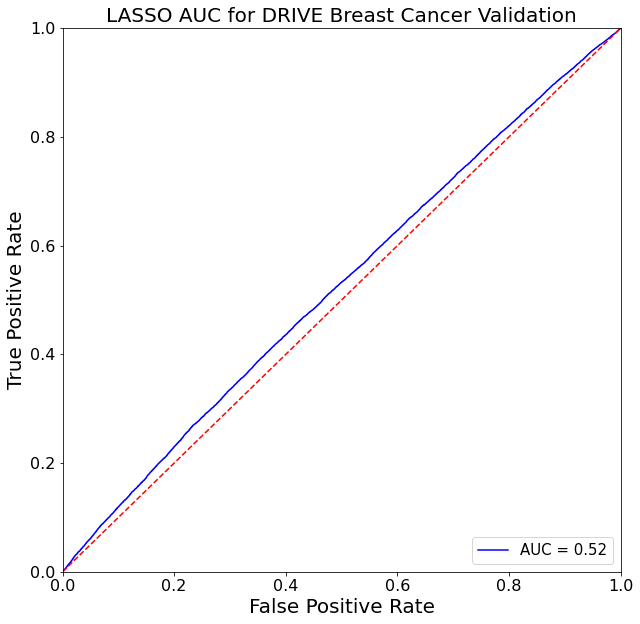

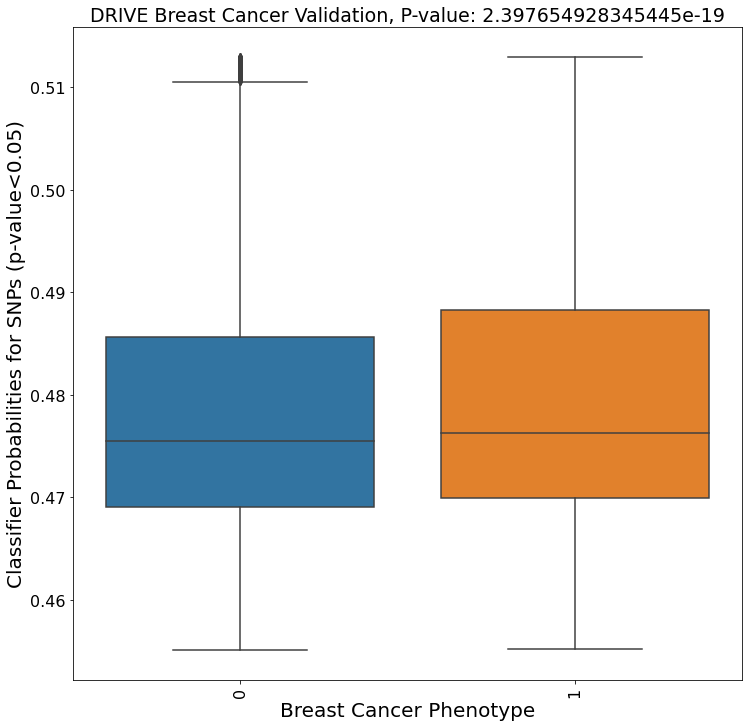

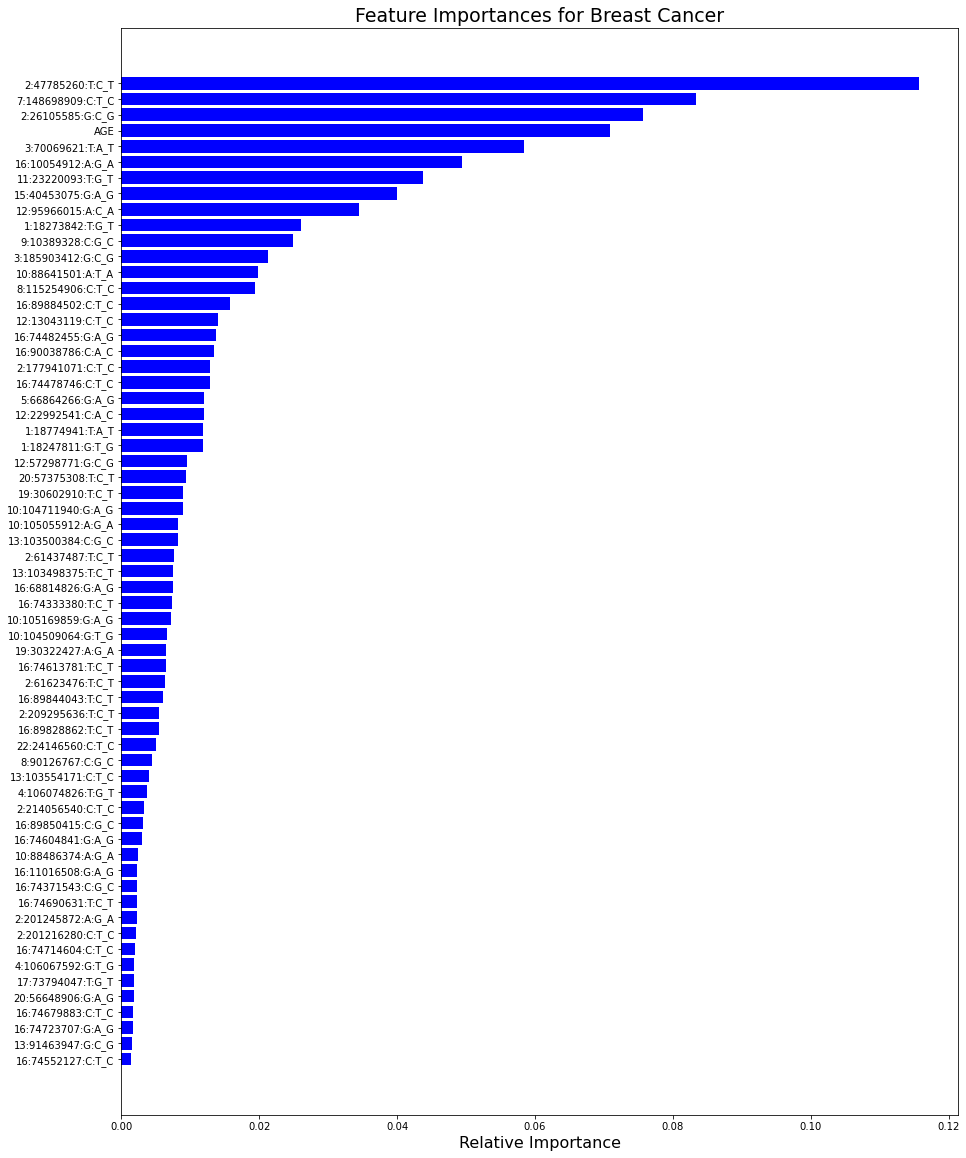

In [35]:
#filter using LASSO regression
# define model

lasso_filtered_snps = []

xgboost_importance_snps = dict()
model = Lasso(alpha=0.001,random_state=10)
# fit model
model.fit(LASSO_x_breast, LASSO_y_breast)
p = model.predict(drive_x)  # test the output by changing values


preds=p

fpr, tpr, threshold = metrics.roc_curve(list(drive_y), preds)
roc_auc = metrics.auc(fpr, tpr)

print(roc_auc)
# method I: plt
fig1 = plt.figure(figsize=(10,10))
plt.title('LASSO AUC for DRIVE Breast Cancer Validation', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=15)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("/cellar/users/sgoudarzi/plots/lasso_xgboost/breast_validation/lasso_auc_breast_drive_validation.png")


#now drop SNPs with low contribution
print("Coefficient 0:", len(LASSO_x_breast.columns.values[model.coef_==0]))
#xgBoost
ukbb_dropped=ukbb_temp.drop(LASSO_x_breast.columns.values[model.coef_==0],axis=1)
cols = list(ukbb_dropped.columns)
cols.remove("breast_pheno")
cols.append("PHENOTYPE")
drive_dropped = drive_temp[cols]

LASSO_X_train_dropped = ukbb_dropped.drop(["breast_pheno"], axis=1)
drive_x_dropped = drive_dropped.drop(["PHENOTYPE"], axis=1)

LASSO_y_train_dropped = ukbb_dropped["breast_pheno"]
drive_y_dropped = drive_dropped["PHENOTYPE"]
os = SMOTE(random_state=10)

columns = LASSO_X_train_dropped.columns
LASSO_X_train_dropped,LASSO_y_train_dropped=os.fit_resample(LASSO_X_train_dropped, LASSO_y_train_dropped)
LASSO_X_train_dropped = pd.DataFrame(data=LASSO_X_train_dropped,columns=columns)
LASSO_y_train_dropped= pd.DataFrame(data=LASSO_y_train_dropped,columns=["breast_pheno"])
LASSO_y_train_dropped = LASSO_y_train_dropped["breast_pheno"]

classifier_xgb = xgboost.XGBRFClassifier(n_estimators =500, random_state = 10,learning_rate=0.1,max_depth=9)
classifier_xgb.fit(LASSO_X_train_dropped, LASSO_y_train_dropped)  

p = classifier_xgb.predict_proba(drive_x_dropped)  # test the output by changing values
p_disc=classifier_xgb.predict_proba(LASSO_X_train_dropped)

# define model evaluation method
# #     evaluate model
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores_training = cross_val_score(classifier_xgb, LASSO_X_train_dropped, LASSO_y_train_dropped, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_testing = cross_val_score(classifier_xgb, drive_x_dropped, drive_y_dropped, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Training AUC", np.mean(np.absolute(scores_training)))
print("Testing AUC", np.mean(np.absolute(scores_testing)))

drive_x_dropped["LASSO_burden"] = p[:, 1]
LASSO_X_train_dropped["LASSO_burden"] = p_disc[:, 1]
LASSO_testing_dataset = drive_x_dropped.copy()
LASSO_testing_dataset["breast_pheno"] = list(drive_y_dropped)
LASSO_training_dataset = LASSO_X_train_dropped.copy()
LASSO_training_dataset["breast_pheno"] = list(LASSO_y_train_dropped)


#testing dataset
fig2 = plt.figure(figsize=(12,12))
sns.boxplot(x="breast_pheno",y="LASSO_burden",data=LASSO_testing_dataset)

cat1 = LASSO_testing_dataset[LASSO_testing_dataset["breast_pheno"]==0]
cat2 = LASSO_testing_dataset[LASSO_testing_dataset["breast_pheno"]==1]
disc_score=cat2["LASSO_burden"].mean()-cat1["LASSO_burden"].mean()
#print("Difference in PRS: "+str(cat2["LASSO_burden"].median()-cat1["LASSO_burden"].median()))
plt.title("DRIVE Breast Cancer Validation, P-value: "+str(stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1]), fontsize=19)

plt.ylabel("Classifier Probabilities for SNPs (p-value<0.05)", fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.xlabel("Breast Cancer Phenotype", fontsize=20)
plt.savefig("/cellar/users/sgoudarzi/plots/lasso_xgboost/breast_validation/xgboost_classifier_burden_breast_drive_validation.png", bbox_inches='tight')
plt.savefig("/cellar/users/sgoudarzi/plots/lasso_xgboost/breast_validation/xgboost_classifier_burden_breast_drive_validation.pdf", bbox_inches='tight')

features = list(LASSO_X_train_dropped.columns)
importances = classifier_xgb.feature_importances_
indices = np.argsort(importances)
for i in indices:
    xgboost_importance_snps[features[i]] = importances[i]
plt.figure(figsize=(15,20))
plt.title('Feature Importances for Breast Cancer', fontsize=19)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance', fontsize=16)
plt.savefig("/cellar/users/sgoudarzi/plots/lasso_xgboost/breast_validation/feature_importance_breast_drive_validation.png", bbox_inches='tight')
plt.savefig("/cellar/users/sgoudarzi/plots/lasso_xgboost/breast_validation/feature_importance_breast_drive_validation.pdf", bbox_inches='tight')
#plt.show()
#return lasso_filtered_snps, xgboost_importance_snps

### Plot Feature Importance Figures

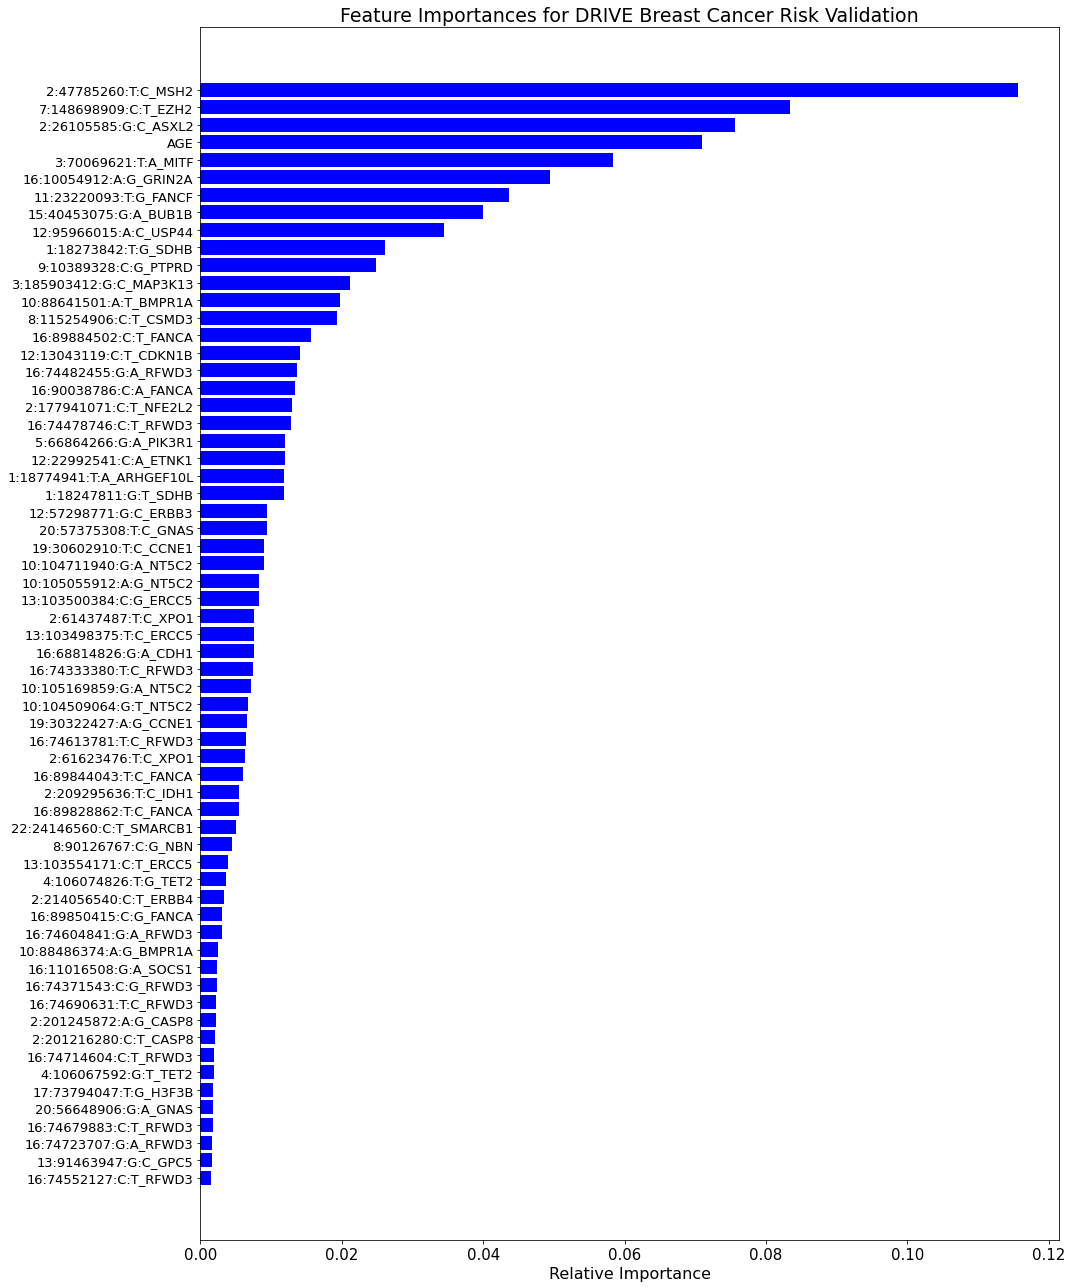

In [99]:
genes = []
snps = []
snp_importances = []
all_importances = []
new_xgboost_importance_snps = dict()
features_new = []
for key in xgboost_importance_snps:
    if ":" in key:
        snp = key.split("_")[0]
        lst = snp.split(":")
        snp_temp = lst[0]+":"+lst[1]
        snps.append(snp)
        temp = cancer_meqtls[cancer_meqtls["SNP"].str.contains(snp_temp)]
        gene = list(temp["probe_gene"])[0]
        genes.append(gene)
        new_xgboost_importance_snps[snp+"_"+gene] = xgboost_importance_snps[key]
        snp_importances.append(xgboost_importance_snps[key])
        all_importances.append(xgboost_importance_snps[key])
        features_new.append(snp+"_"+gene)
    else:
        new_xgboost_importance_snps[key] = xgboost_importance_snps[key]
        features_new.append(key)
        all_importances.append(xgboost_importance_snps[key])

feature_importance_breast_table = pd.DataFrame({"SNP":snps, "Gene":genes, "Feature_Importance":snp_importances})
all_importances = np.array(all_importances)
features_new = np.array(features_new)
# indices_new = np.argsort(importances)

plt.figure(figsize=(15,18))
plt.title('Feature Importances for DRIVE Breast Cancer Risk Validation', fontsize=19)
plt.barh(range(len(features_new)), list(all_importances), color='b', align='center')
plt.yticks(range(len(features_new)), list(features_new), fontsize=13)
plt.xticks(fontsize=15)
plt.xlabel('Relative Importance', fontsize=16)
plt.tight_layout()
plt.savefig("/cellar/users/sgoudarzi/plots/lasso_xgboost/breast_validation/feature_importance_breast_drive_validation.png", bbox_inches='tight')
plt.savefig("/cellar/users/sgoudarzi/plots/lasso_xgboost/breast_validation/feature_importance_breast_drive_validation.pdf", bbox_inches='tight')


In [82]:
feature_importance_breast_table = feature_importance_breast_table.sort_values(by=['Feature_Importance'], ascending=False)
feature_importance_breast_table = feature_importance_breast_table.reset_index(drop=True)
feature_importance_breast_table

,SNP,Gene,Feature_Importance
0,2:47785260:T:C,MSH2,0.115646
1,7:148698909:C:T,EZH2,0.083382
2,2:26105585:G:C,ASXL2,0.075681
3,3:70069621:T:A,MITF,0.058338
4,16:10054912:A:G,GRIN2A,0.049459
...,...,...,...
57,20:56648906:G:A,GNAS,0.001830
58,16:74679883:C:T,RFWD3,0.001714
59,16:74723707:G:A,RFWD3,0.001631
60,13:91463947:G:C,GPC5,0.001574


In [83]:
feature_importance_breast_table.to_csv("../plots/lasso_xgboost/breast_validation/feature_importance_breast_table.csv", index=False)

In [73]:
print(np.mean(cat1["LASSO_burden"]), np.mean(cat2["LASSO_burden"]))

0.47919151186943054 0.4801464080810547


### Use XGBoost Probabilities for PRS and Plot DRIVE PRS Quantile Plot

In [74]:
xgboost_drive_prs = LASSO_testing_dataset.rename(columns={"LASSO_burden":"PRS", "breast_pheno":"breast"})
xgboost_drive_prs["FID"] = list(xgboost_drive_prs.index)
xgboost_drive_prs

,19:30322427:A:G_A,19:30602910:T:C_T,20:56648906:G:A_G,20:57375308:T:C_T,8:90126767:C:G_C,8:115254906:C:T_C,15:40453075:G:A_G,16:10054912:A:G_A,16:11016508:G:A_G,16:68814826:G:A_G,...,10:105055912:A:G_A,10:105169859:G:A_G,17:73794047:T:G_T,11:23220093:T:G_T,22:24146560:C:T_C,5:66864266:G:A_G,AGE,PRS,breast,FID
IID,,,,,,,,,,,,,,,,,,,,,
BCAC-54974792_282470,2,1,2,0,2,2,2,0,1,1,...,2,1,2,1,0,2,64.0,0.507775,1,BCAC-54974792_282470
BCAC-51014473_282566,0,1,2,0,2,1,2,0,2,2,...,2,1,2,2,2,0,45.0,0.480504,1,BCAC-51014473_282566
BCAC-12089156_282662,0,1,2,1,2,1,2,0,2,1,...,2,2,2,2,0,1,49.0,0.476771,1,BCAC-12089156_282662
BCAC-95658930_282758,0,1,2,0,2,0,2,0,2,2,...,2,1,2,1,0,1,42.0,0.463993,1,BCAC-95658930_282758
BCAC-51443138_282854,0,1,2,0,2,1,2,0,2,1,...,1,2,2,2,0,1,35.0,0.472478,1,BCAC-51443138_282854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BCAC-84531373_101279,0,2,1,2,2,1,2,0,2,2,...,2,0,1,1,0,2,59.0,0.481301,0,BCAC-84531373_101279
BCAC-19508141_102762,0,2,2,0,2,1,1,0,2,1,...,1,1,2,2,0,0,64.0,0.507198,1,BCAC-19508141_102762
BCAC-71331053_105134,1,1,2,0,2,2,1,1,2,2,...,1,2,2,1,0,1,71.0,0.488274,1,BCAC-71331053_105134


In [75]:
xgboost_drive_prs["breast"].value_counts()

1    32428
0    26374
Name: breast, dtype: int64

In [37]:
xgboost_drive_odds=quantile_plot(xgboost_drive_prs,"breast ~ group",10,"logistic")

5880 5880
0    5880
1    5880
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.687942
         Iterations 4


<ipython-input-36-2895ffe7993f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


5880 5880
0    5880
1    5880
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.689447
         Iterations 4
5880 5880
0    5880
1    5880
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.688677
         Iterations 4
5880 5880
0    5880
1    5880
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.687718
         Iterations 4
5880 5880
0    5880
1    5880
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.686471
         Iterations 4
5880 5880
1    5880
Name: group, dtype: int64


<ipython-input-36-2895ffe7993f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)
<ipython-input-36-2895ffe7993f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)
<ipython-input-36-2895ffe7993f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

5880 5880
0    5880
1    5880
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.685587
         Iterations 4
5880 5880
0    5880
1    5880
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.683995
         Iterations 4
5880 5880
0    5880
1    5880
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.684096
         Iterations 4
5877 5880
0    5880
1    5877
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.684547
         Iterations 4


<ipython-input-36-2895ffe7993f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)
<ipython-input-36-2895ffe7993f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)
<ipython-input-36-2895ffe7993f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [38]:
xgboost_drive_odds

,quant,odds,se
0,0.0,0.920210,0.037079
1,10.0,0.811124,0.037023
2,20.0,0.881425,0.037052
3,30.0,0.930349,0.037087
4,40.0,0.979529,0.037134
5,50.0,1.000000,0.000000
6,60.0,1.009717,0.037167
7,70.0,1.058457,0.037227
8,80.0,1.055516,0.037223
9,90.0,1.042192,0.037211


In [76]:
bottom_20_prs_drive = xgboost_drive_prs[(xgboost_drive_prs["PRS"]<xgboost_drive_prs["PRS"].quantile(0.2))]
top_20_prs_drive = xgboost_drive_prs[(xgboost_drive_prs["PRS"]>xgboost_drive_prs["PRS"].quantile(0.8))]

In [77]:
table_2d_drive = [[len(bottom_20_prs_drive[bottom_20_prs_drive["breast"]==0]), len(top_20_prs_drive[top_20_prs_drive["breast"]==0])], [len(bottom_20_prs_drive[bottom_20_prs_drive["breast"]==1]), len(top_20_prs_drive[top_20_prs_drive["breast"]==1])]]
odd_ratio, p_value = stats.fisher_exact(table_2d_drive)
print(p_value)

1.465902409464863e-13


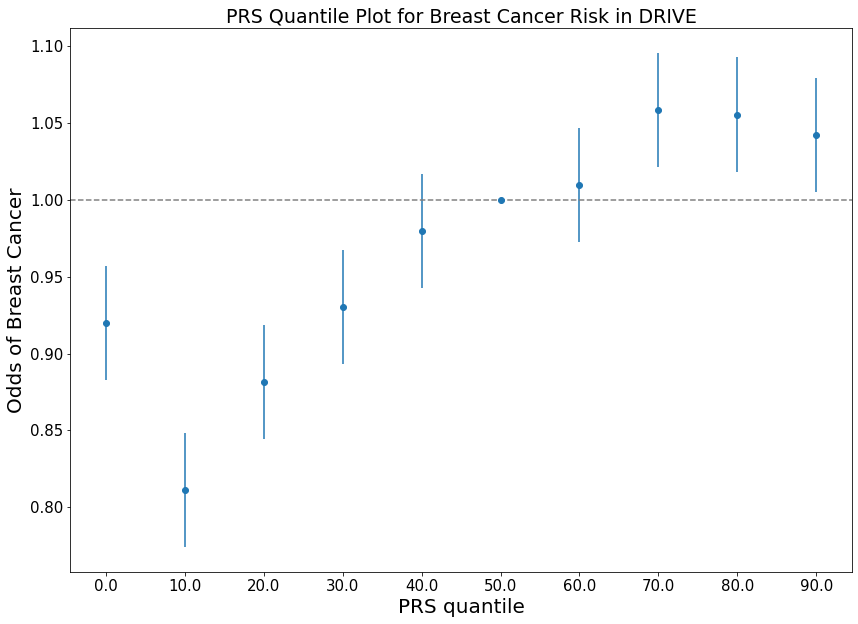

In [39]:
fig2 = plt.figure(figsize=(14,10))
plt.errorbar(x=xgboost_drive_odds["quant"].tolist(),y=xgboost_drive_odds["odds"].tolist(),yerr=xgboost_drive_odds["se"].tolist(),fmt="o")
plt.xlabel("PRS quantile", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Odds of Breast Cancer", fontsize=20)
plt.axhline(1,linestyle="--",color="gray")
plt.title("PRS Quantile Plot for Breast Cancer Risk in DRIVE" ,fontsize=19)
plt.savefig("/cellar/users/sgoudarzi/plots/lasso_xgboost/breast_validation/quantile_breast_drive_classifier.png")
plt.savefig("/cellar/users/sgoudarzi/plots/lasso_xgboost/breast_validation/quantile_breast_drive_classifier.pdf")